## 시계열 데이터 이상치 탐지

- 이상치 탐지(Anomaly Detection)는 정상 데이터의 패턴을 학습한 모델을 통해, 정상 패턴과 다른 데이터를 이상치로 식별하는 기법.     
- 주로 비정상적인 이벤트나 데이터를 감지하는 데 활용되며, 금융 사기, 네트워크 침입, 공정 이상 감지 등 여러 분야에 적용됨.
- 오토인코더나 transformer 같은 재구성 loss를 통해 판단하거나 GAN 같은 생성 모델을 사용하기도 함
- RNN 기반 모델은 예측 오차를 통해 이상치를 탐지


(1000, 50)


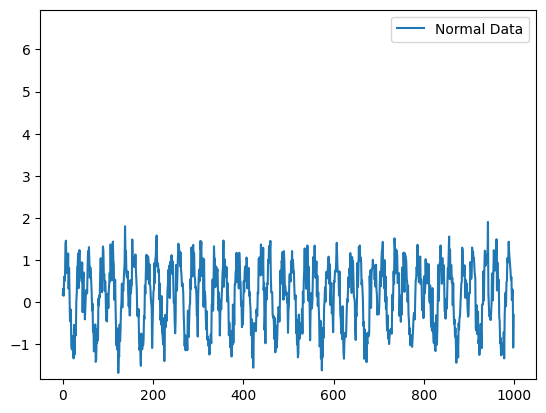

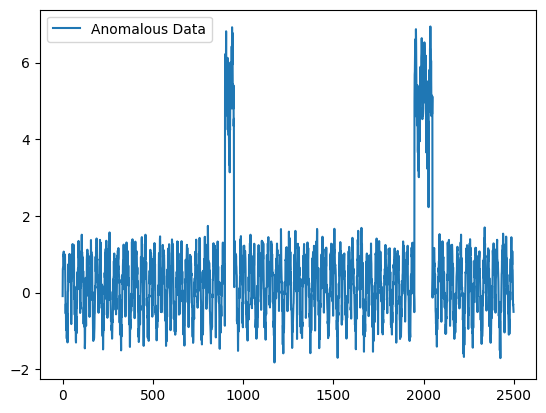

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1004)

# 데이터 생성 (간단한 시계열 데이터 + 이상치)
def create_data(sequence_length=50, num_data=1000, anomaly= True):
    data = []
    for i in range(num_data):
        base_pattern = np.sin(np.linspace(0, 10, sequence_length))  # 사인파 기반 패턴
        noise = np.random.normal(0, 0.3, sequence_length)  # 노이즈 추가
        seq = base_pattern + noise
        if anomaly:
            if np.random.rand() > 0.95:  # 일부 시퀀스에 이상치 추가
                seq += np.random.normal(5, 0.5, sequence_length)
        data.append(seq)
    return np.array(data)

# 데이터 생성
normal_data = create_data(anomaly=False)
train_data = torch.tensor(normal_data, dtype=torch.float32).unsqueeze(-1)  # (batch_size, seq_len, input_size)
normal_data2 = create_data(sequence_length=50, num_data=100, anomaly=False)
val_nm_data = torch.tensor(normal_data2, dtype=torch.float32).unsqueeze(-1)
abnormal_data = create_data(sequence_length=50, num_data=100, anomaly=True)
val_an_data = torch.tensor(abnormal_data, dtype=torch.float32).unsqueeze(-1)
abnormal_data = create_data(sequence_length=50, num_data=50, anomaly=True)
test_data = torch.tensor(abnormal_data, dtype=torch.float32).unsqueeze(-1)

print(normal_data.shape)
plt.plot(normal_data[0:20].reshape(-1), label='Normal Data')
plt.ylim(np.min(abnormal_data), np.max(abnormal_data))
plt.legend()
plt.show()

plt.plot(abnormal_data.ravel(), label='Anomalous Data')
plt.legend()
plt.show()

In [4]:
# LSTM 모델 정의
class LSTMAnomalyDetector(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMAnomalyDetector, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])  # 마지막 LSTM 출력만 사용
        return out

# 모델 학습 설정
model = LSTMAnomalyDetector()
criterion = nn.MSELoss()  # 시계열 재구성 오류를 계산
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
# 학습
num_epochs = 200
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    outputs = model(train_data)  # 마지막 시점 제외
    loss = criterion(outputs, train_data[:, -1, :])
    train_losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(val_nm_data)
        val_loss = criterion(val_outputs, val_nm_data[:, -1, :])
        val_losses.append(val_loss.item())

    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

Epoch [20/200], Loss: 0.0877, Val Loss: 0.0759
Epoch [40/200], Loss: 0.0871, Val Loss: 0.0821
Epoch [60/200], Loss: 0.0837, Val Loss: 0.0746
Epoch [80/200], Loss: 0.0817, Val Loss: 0.0725
Epoch [100/200], Loss: 0.0784, Val Loss: 0.0704
Epoch [120/200], Loss: 0.0730, Val Loss: 0.0664
Epoch [140/200], Loss: 0.0631, Val Loss: 0.0582
Epoch [160/200], Loss: 0.0430, Val Loss: 0.0391
Epoch [180/200], Loss: 0.0085, Val Loss: 0.0068
Epoch [200/200], Loss: 0.0022, Val Loss: 0.0011


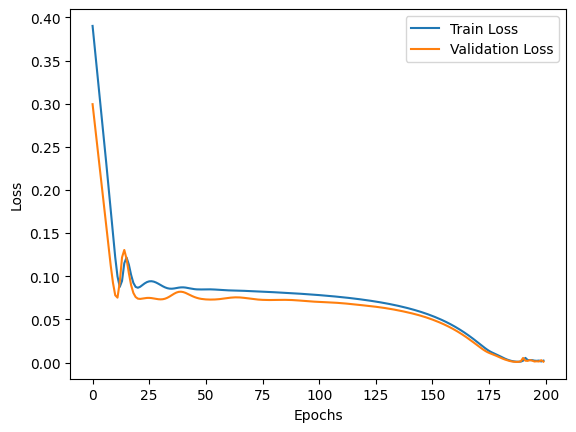

In [6]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

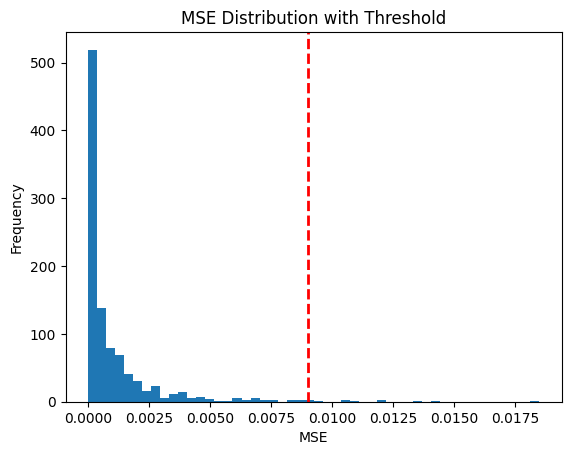

0.009022197


In [7]:
# 이상치 탐지 threshold 설정
model.eval()
with torch.no_grad():
    predictions = model(train_data)
    mse = torch.mean((train_data[:, -1, :] - predictions) ** 2, dim=1).numpy()
    threshold = np.percentile(mse, 99)  # 상위 5%를 이상치로 설정
    anomalies = mse > threshold

plt.hist(mse, bins=50)
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2)
plt.title('MSE Distribution with Threshold')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.show()
print(threshold)

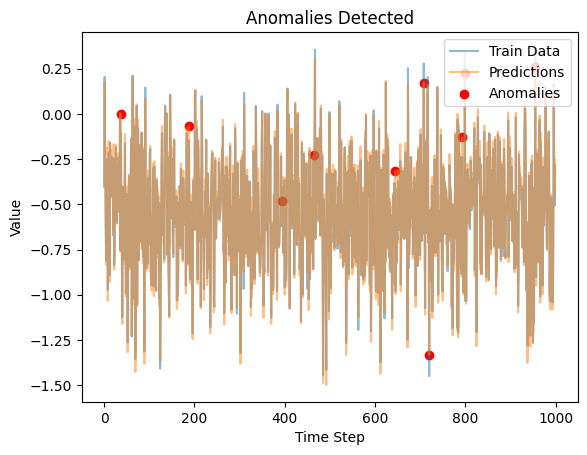

In [8]:
plt.plot(train_data[:, -1, :], label='Train Data', alpha=0.5)
plt.plot(predictions, label='Predictions', alpha=0.5)
plt.scatter(np.where(anomalies)[0], predictions[anomalies], color='red', label='Anomalies')
plt.title('Anomalies Detected')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

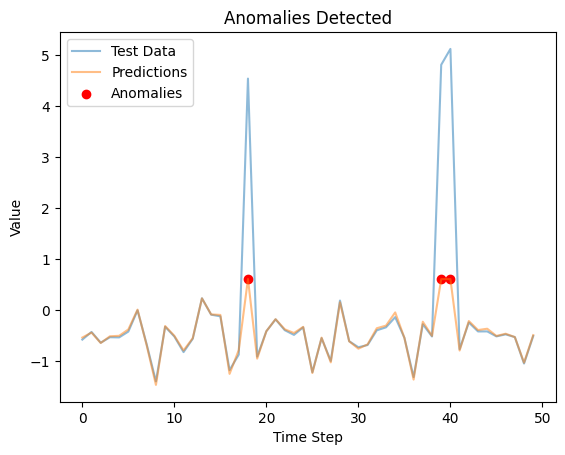

In [9]:
# 이상치 탐지 threshold 설정
model.eval()
with torch.no_grad():
    predictions = model(test_data)
    mse = torch.mean((test_data[:, -1, :] - predictions) ** 2, dim=1).numpy()
    anomalies = mse > threshold

plt.plot(test_data[:, -1, :], label='Test Data', alpha=0.5)
plt.plot(predictions, label='Predictions', alpha=0.5)
plt.scatter(np.where(anomalies)[0], predictions[anomalies], color='red', label='Anomalies')
plt.title('Anomalies Detected')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()